In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
import numpy as np
import cv2
import PIL.Image as Image
import matplotlib.pyplot as plt

In [2]:
IMAGE_SHAPE = (224,224)
classifier = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4",input_shape=IMAGE_SHAPE+(3,))
])
#(224,224)+(3,) is adding RGB dimension

In [3]:
gold_fish = Image.open('goldfish.jpg').resize(IMAGE_SHAPE)

In [4]:
gold_fish = np.array(gold_fish)/255
gold_fish[np.newaxis,...].shape

(1, 224, 224, 3)

In [5]:
result = classifier.predict(gold_fish[np.newaxis,...])

In [6]:
result.shape

(1, 1001)

In [7]:
predicted_label_index = np.argmax(result)
predicted_label_index

2

In [8]:
with open('ImageNetLabels.txt','r') as f:
    image_labels = f.read().splitlines()
image_labels[predicted_label_index]

'goldfish'

In [9]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)

In [10]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('datasets/flower_photos')

In [11]:
flowes_images_dict = {
    'roses': list(data_dir.glob('roses/*.jpg')),
    'daisy': list(data_dir.glob('daisy/*.jpg')),
    'dandelion': list(data_dir.glob('dandelion/*.jpg')),
    'sunflowers': list(data_dir.glob('sunflowers/*.jpg')),
    'tulips': list(data_dir.glob('tulips/*.jpg'))
}

flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4
}

In [12]:
x, y = [], []

for flower_name, images in flowes_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(IMAGE_SHAPE))
        x.append(resized_img)
        y.append(flowers_labels_dict[flower_name])
        
x = np.array(x)
y = np.array(y)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=0)

x_train_scaled = x_train / 255
x_test_scaled = x_test / 255

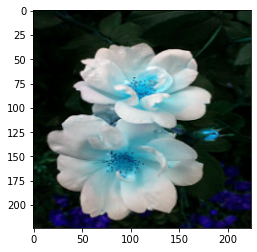

In [13]:
plt.imshow(x[0])

In [14]:
predicted = classifier.predict(np.array([x[0],x[1],x[2]]))
predicted = np.argmax(predicted,axis=1)
predicted

array([795, 880, 795], dtype=int64)

In [18]:
image_labels[795],image_labels[880],image_labels[795]

('shower curtain', 'umbrella', 'shower curtain')

In [19]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
#excluding last layer (classification->feature_vector)

In [21]:
pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model,input_shape=(224,224,3),trainable=False)

In [22]:
num_of_flowers = 5

model = keras.Sequential([
    pretrained_model_without_top_layer,
    keras.layers.Dense(num_of_flowers)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [24]:
model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc'])

model.fit(x_train_scaled,y_train,epochs=5)

Epoch 1/5
92/92 [==============================] - 12s 95ms/step - loss: 1.0945 - acc: 0.5853
Epoch 2/5
92/92 [==============================] - 8s 90ms/step - loss: 0.4220 - acc: 0.8612
Epoch 3/5
92/92 [==============================] - 8s 90ms/step - loss: 0.3144 - acc: 0.8987
Epoch 4/5
92/92 [==============================] - 8s 90ms/step - loss: 0.2611 - acc: 0.9254
Epoch 5/5
92/92 [==============================] - 8s 90ms/step - loss: 0.2194 - acc: 0.9353
